In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from pclib.nn.models import FCClassifierSSLI
from pclib.nn.layers import PrecisionWeighted
from pclib.optim.train_ss_li import train
from pclib.utils.plot import plot_stats
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import vfe, format_y, reTanh
from pclib.utils.customdataset import PreloadedDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [37]:

class TanhTransform(object):
    def __init__(self, a=1., b=0., c=1.0):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, img):
        return ((img * self.a).tanh() + self.b) * self.c

class InvTanhTransform(object):
    def __call__(self, img):
        num = 1 + img
        div = (1 - img).clamp(min=1e-6)
        m = 0.5 * torch.log(num / div)
        return m

class SigmoidTransform(object):
    def __call__(self, img):
        return img.sigmoid()
    
class ReLUTanhTransform(object):
    def __call__(self, img):
        return F.relu(img.tanh())

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # InvTanhTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 1000
# dataset = torch.utils.data.Subset(dataset, range(length))

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

  0%|          | 0/48000 [00:00<?, ?it/s]

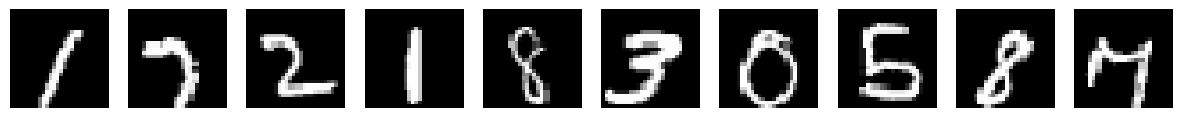

Max value:  tensor(2.8215, device='cuda:0')
Min value:  tensor(-0.4242, device='cuda:0')


In [39]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [41]:
seed = 42
torch.manual_seed(seed)

model = FCClassifierSSLI(
    input_size=INPUT_SHAPE, 
    num_classes=NUM_CLASSES, 
    hidden_sizes=[600, 250, 120],
    bias=True, 
    symmetric=True,
    precision_weighted=False,
    actv_fn=reTanh,
    steps=100,
    gamma=0.34,
    beta=1.0,
    ).to(device)
step = 0
stats = None

layer 1: abs_mean: 0.0017, mean: 0.0017, std: 0.0408, max: 1.0000, min: -0.0000
layer 2: abs_mean: 0.0040, mean: 0.0040, std: 0.0631, max: 1.0000, min: -0.0000
layer 3: abs_mean: 0.0083, mean: 0.0083, std: 0.0909, max: 1.0000, min: -0.0000


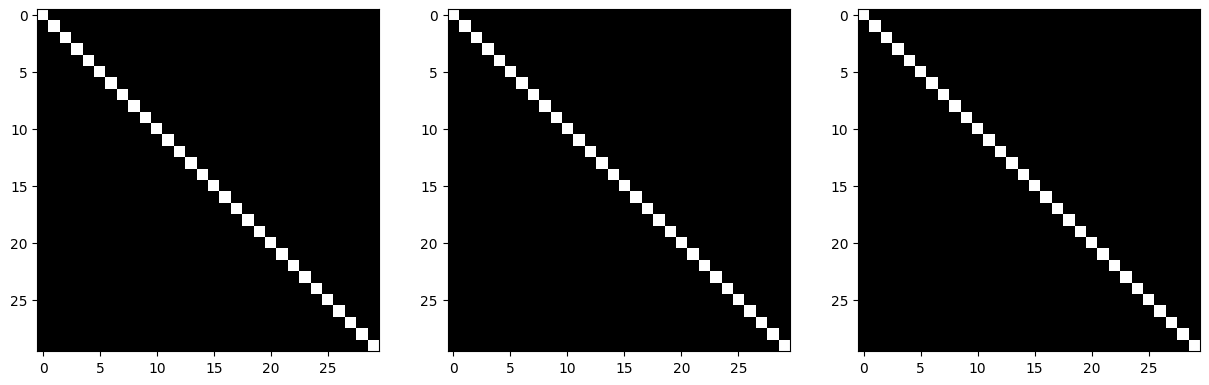

In [42]:
plt.figure(figsize=(15, 5))
for i, layer in enumerate(model.layers):
    if i == 0:
        continue
    # mat = layer.weight_lat
    mat = layer.weight_lat * layer.lat_conn_mat
    # mat = layer.weight_lat - layer.weight_lat.diag().diag()
    # mat = layer.weight_lat - torch.eye(layer.weight_lat.shape[0]).to(device)
    abs_mean = mat.abs().mean().item()
    mean = mat.mean().item()
    std = mat.std().item()
    maxi = mat.max().item()
    mini = mat.min().item()
    print(f"layer {i}: abs_mean: {abs_mean:.4f}, mean: {mean:.4f}, std: {std:.4f}, max: {maxi:.4f}, min: {mini:.4f}")
    # show mat graphically
    plt.subplot(1, 3, i)
    plt.imshow(mat[:30,:30].detach().cpu(), cmap='gray')
plt.show()

torch.Size([600, 600])
layer 1: abs_mean: 0.0017, mean: 0.0017, std: 0.0408, max: 1.0000, min: -0.0000
torch.Size([250, 250])
layer 2: abs_mean: 0.0040, mean: 0.0040, std: 0.0631, max: 1.0000, min: -0.0000
torch.Size([120, 120])
layer 3: abs_mean: 0.0083, mean: 0.0083, std: 0.0909, max: 1.0000, min: -0.0000


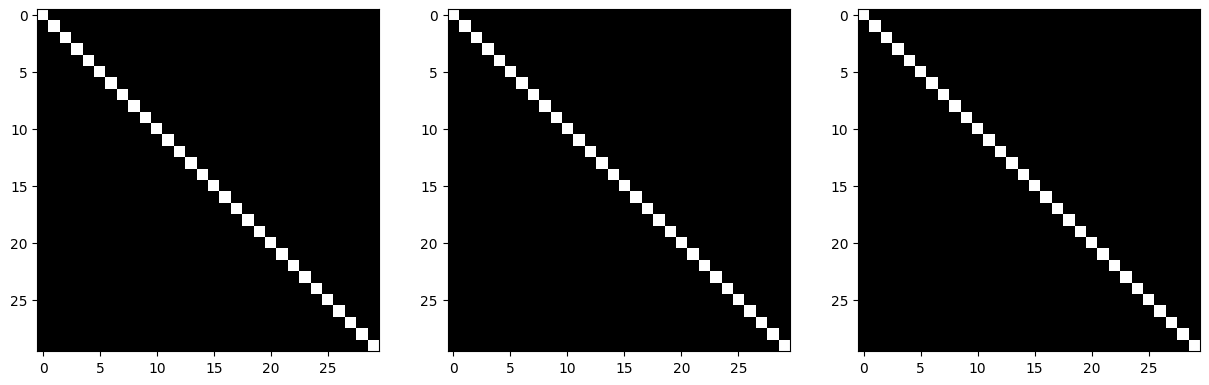

In [35]:
plt.figure(figsize=(15, 5))
for i, layer in enumerate(model.layers):
    if i == 0:
        continue
    # mat = layer.weight_lat
    mat = layer.weight_lat * layer.lat_conn_mat
    # mat = layer.weight_lat - layer.weight_lat.diag().diag()
    # mat = layer.weight_lat - torch.eye(layer.weight_lat.shape[0]).to(device)
    print(mat.shape)
    abs_mean = mat.abs().mean().item()
    mean = mat.mean().item()
    std = mat.std().item()
    maxi = mat.max().item()
    mini = mat.min().item()
    print(f"layer {i}: abs_mean: {abs_mean:.4f}, mean: {mean:.4f}, std: {std:.4f}, max: {maxi:.4f}, min: {mini:.4f}")
    # show mat graphically
    plt.subplot(1, 3, i)
    plt.imshow(mat[:30,:30].detach().cpu(), cmap='gray')

plt.show()


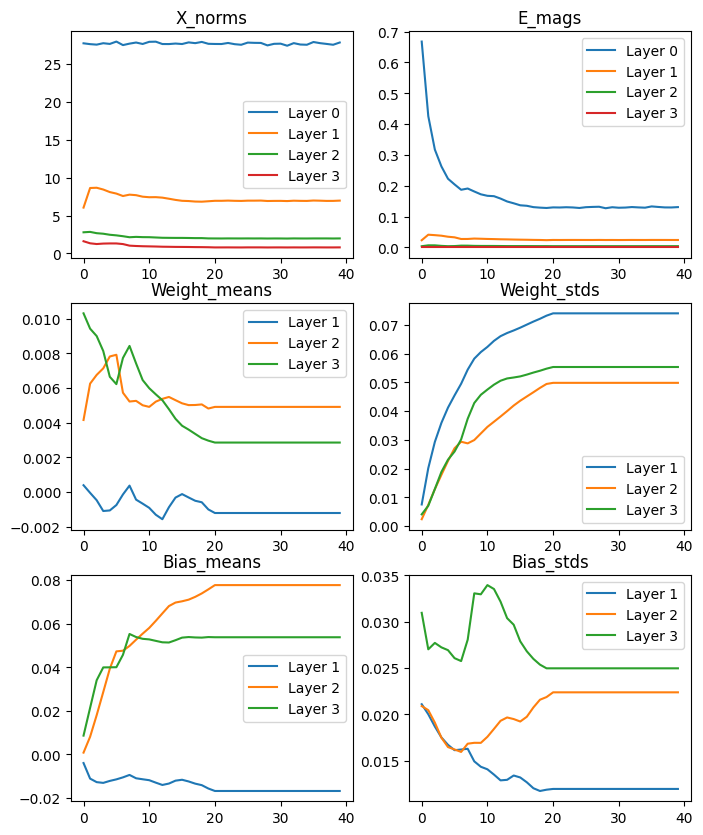

In [43]:
# Train Loop
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
BATCH_SIZE = 1000
REG_COEFF = 1.0

step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    pc_lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    step=step, 
    stats=stats,
    device=device,
    pc_optim='AdamW',
    c_optim=None,
)
LEARNING_RATE = 0.0
NUM_EPOCHS = 20
step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    pc_lr=LEARNING_RATE, 
    c_lr=0.1,
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    step=step, 
    stats=stats,
    device=device,
    pc_optim='AdamW',
    c_optim='AdamW',
)

plot_stats(stats, model)

layer 1 5 largest values:  [[0.5150482058525085, 0.5119600296020508, 0.4717060923576355, 0.4454697072505951, 0.41483616828918457], [0.5942434072494507, 0.5256925821304321, 0.5182284712791443, 0.5078781247138977, 0.43746140599250793], [0.538262128829956, 0.535843551158905, 0.5039463639259338, 0.4873073399066925, 0.41694527864456177], [0.5311524868011475, 0.5152823328971863, 0.49833282828330994, 0.44396519660949707, 0.3737972378730774], [0.5261130928993225, 0.5169944763183594, 0.45222288370132446, 0.3729971945285797, 0.35965946316719055], [0.716865599155426, 0.5212373733520508, 0.5147140026092529, 0.441968709230423, 0.3664344549179077], [0.5382921099662781, 0.5379422903060913, 0.5332673192024231, 0.5264937877655029, 0.5252323746681213], [0.6924851536750793, 0.6069005131721497, 0.5222477912902832, 0.47939950227737427, 0.4741209149360657], [0.5755393505096436, 0.5103422403335571, 0.5063705444335938, 0.41851988434791565, 0.35845351219177246], [0.5395931005477905, 0.5322054028511047, 0.50151

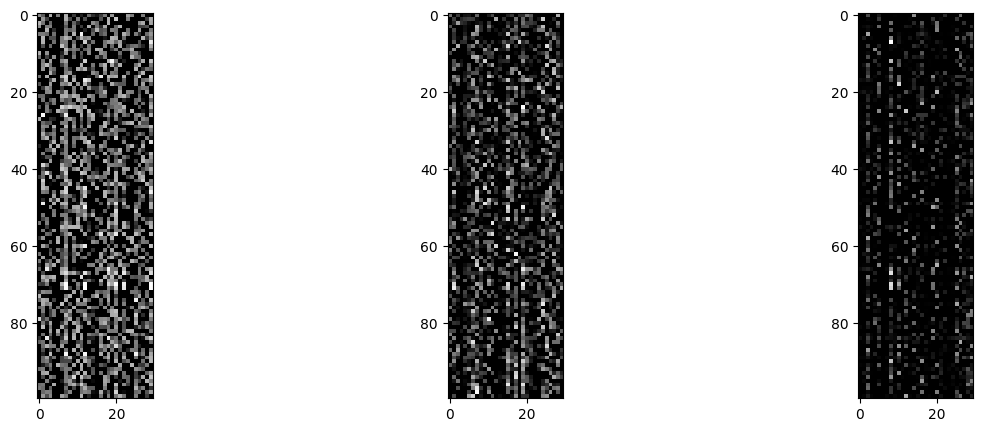

In [44]:
# Check Winner takes all
# is there an SDR?

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_x = next(iter(train_loader))[0].flatten(1)
val_x = next(iter(val_loader))[0].flatten(1)
train_out, train_state = model(train_x, steps=1000)
val_out, val_state = model(val_x)

plt.figure(figsize=(15, 5))
for i, layer in enumerate(model.layers):
    if i == 0:
        continue
    vals = layer.actv_fn(train_state[i]['x'][:100,:30])
    print(f"layer {i} 5 largest values: ", vals.topk(5, dim=1)[0].squeeze().tolist())
    plt.subplot(1, 3, i)
    plt.imshow(vals.detach().cpu(), cmap='gray')


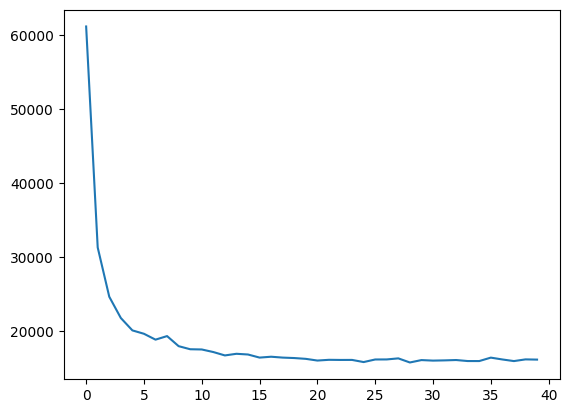

In [45]:
plt.plot(stats['train_corr'])

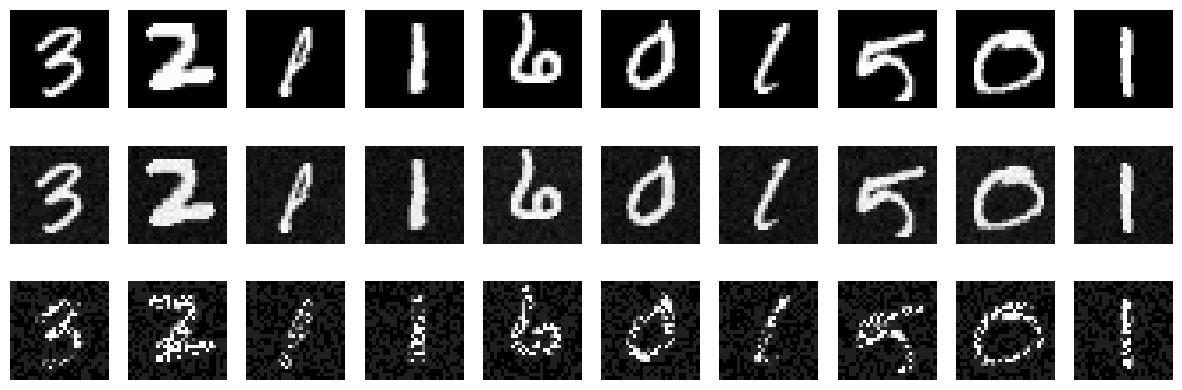

In [10]:
# get 10 images
images = []
noisy_images = []
partial_images = []
labels = []
for i in range(10):
    img, _ = val_dataset[i]
    images.append(img)
    noisy_images.append(img + torch.randn_like(img) * 0.1)
    partial_images.append(img * (torch.rand_like(img) < 0.5))
    labels.append(label)

# show images
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i, ax in enumerate(axes[0]):
    ax.imshow(images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(noisy_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[2]):
    ax.imshow(partial_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

images = torch.stack(images).flatten(1)
noisy_images = torch.stack(noisy_images).flatten(1)
partial_images = torch.stack(partial_images).flatten(1)

torch.Size([10, 784])


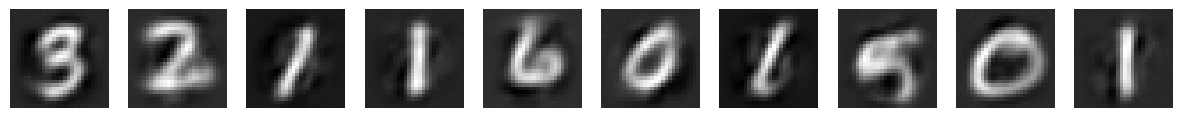

In [11]:
# reconstruct noisy images
out, state = model.reconstruct(noisy_images)
print(out.shape)


# show reconstructed images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(out[i].cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')

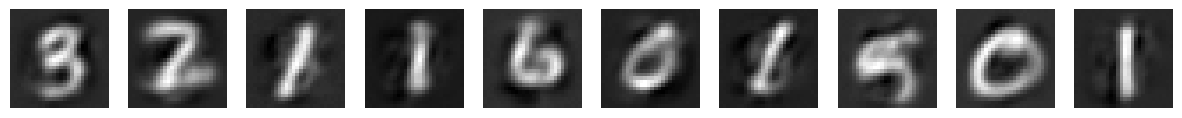

In [12]:
# reconstruct partial images
out, state = model.reconstruct(partial_images)

# show reconstructed images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(out[i].cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')

In [15]:
targets = torch.arange(NUM_CLASSES).to(device)
images = model.generate(targets)

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.detach().squeeze().cpu().view(28,28), cmap='gray')
    ax.axis('off')

NotImplementedError: 

0.8946666666666667


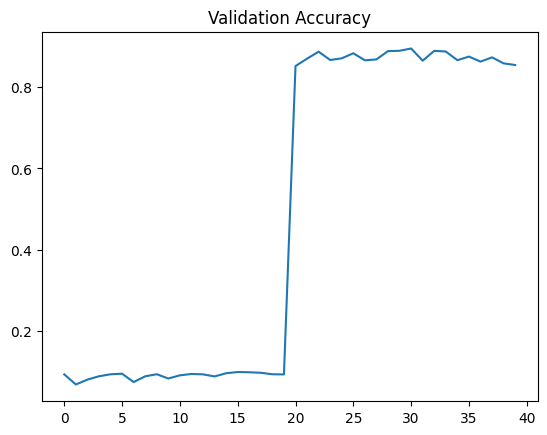

In [46]:
print(max(stats['val_acc']))
plt.plot(stats['val_acc'])
plt.title("Validation Accuracy")
plt.show()

In [28]:
for layer in model.layers:
    if layer.weight_td is not None:
        print(layer.weight_lat.abs().mean(), layer.weight_td.abs().mean())
    else:
        print(layer.weight_lat.abs().mean())

tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0441, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0743, device='cuda:0', grad_fn=<MeanBackward0>)


In [65]:
max(stats['val_acc'])

0.89175

In [7]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

Current Val Acc: 0.9848333333333333 | error_rate: 1.52 %


In [7]:
# # Shows statistics over multiple models. models = [model1, model2, ...]


# train_vfes = torch.tensor([stats[i]['train_vfe'][-1] for i in range(num_models)])
# val_vfes = torch.tensor([stats[i]['val_vfe'][-1] for i in range(num_models)])
# val_accs = torch.tensor([stats[i]['val_acc'][-1] for i in range(num_models)])

# # Show statistics across models, std is nan if num_models = 1
# print(f"Tra VFE - mean: {train_vfes.mean():.3f} | std: {train_vfes.std():.3f} | min: {train_vfes.min():.3f} | max: {train_vfes.max():.3f}")
# print(f"Val VFE - mean: {val_vfes.mean():.3f} | std: {val_vfes.std():.3f} | min: {val_vfes.min():.3f} | max: {val_vfes.max():.3f}")
# print(f"Val Acc - mean: {val_accs.mean():.3f} | std: {val_accs.std():.3f} | min: {val_accs.min():.3f} | max: {val_accs.max():.3f}")

NameError: name 'num_models' is not defined

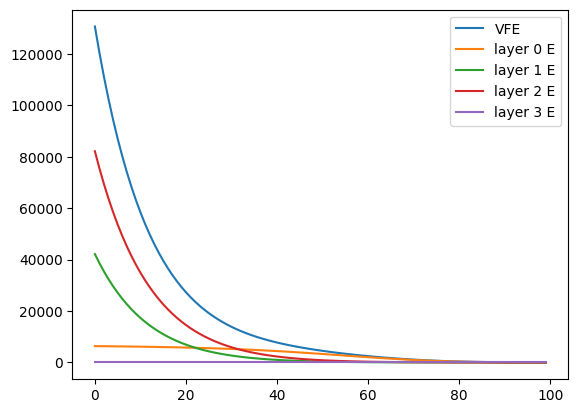

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


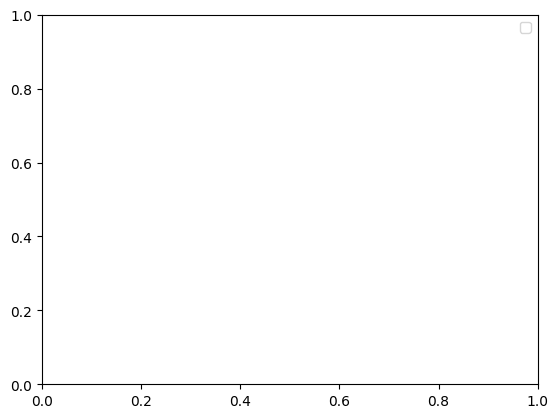

([130682.796875,
  120435.1015625,
  111009.8203125,
  102343.515625,
  94374.125,
  87047.25,
  80312.0625,
  74121.671875,
  68430.0625,
  63198.859375,
  58391.3125,
  53973.9453125,
  49913.6015625,
  46181.7265625,
  42753.4765625,
  39604.2109375,
  36708.4140625,
  34049.1484375,
  31605.19140625,
  29358.87890625,
  27294.70703125,
  25395.68359375,
  23650.666015625,
  22046.1171875,
  20569.7265625,
  19211.09765625,
  17960.287109375,
  16807.326171875,
  15746.12109375,
  14765.9140625,
  13861.9091796875,
  13026.041015625,
  12253.5048828125,
  11537.7724609375,
  10873.7373046875,
  10257.75390625,
  9684.9619140625,
  9151.087890625,
  8653.2275390625,
  8187.853515625,
  7751.4931640625,
  7341.84716796875,
  6956.4599609375,
  6593.6064453125,
  6250.4130859375,
  5925.3369140625,
  5617.2216796875,
  5324.1689453125,
  5044.509765625,
  4777.939453125,
  4522.88916015625,
  4278.6064453125,
  4044.5009765625,
  3819.712890625,
  3603.593505859375,
  3395.861328125,
 

In [15]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images.view(images.shape[0], -1)
y = format_y(y, 10)
track_vfe(model, x, steps=100, plot_Es=True)

In [12]:
assert isinstance(model.layers[0], PrecisionWeighted), "This cell only works for PrecisionWeighted layers"
# show diag of weight_var matrix as 28x28 image for layer 0
model = model
layer = 0
weight_var = model.layers[0].weight_var.detach().cpu().numpy()
# weight_var = model.layers[-1].weight_var.diag().reshape(28,28).detach().cpu().numpy()
plt.imshow(weight_var, cmap='gray')
plt.colorbar()
plt.show()
weight_var.min(), weight_var.max()


AssertionError: This cell only works for PrecisionWeighted layers